In [11]:
# Import modules and define directories
%matplotlib inline
import os,sys
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


workpath = os.getcwd()
rootpath = os.path.dirname(workpath)
libpath = rootpath + "/libs/"
inppath = rootpath + "/input/"
figpath = workpath + "/figs/"
qgispath = workpath + "/geo/"
primpath = rootpath + "/primnet/out/"

sys.path.append(libpath)
from pyValidationlib import Validate,GetSynthNet,Link
from pyExtractDatalib import GetRoads
print("Imported modules")

Imported modules


In [12]:
sublist = [121143, 121144, 147793, 148717, 148718, 148719, 148720, 148721, 148723,
       150353, 150589, 150638, 150692, 150722, 150723, 150724, 150725, 150726, 
       150727, 150728]
synth_net = GetSynthNet(primpath+'prim-network/',sublist)
sgeom = nx.get_edge_attributes(synth_net,'geometry')
synthgeom = {e:Link(sgeom[e]) for e in sgeom}
glength = {e:synthgeom[e].geod_length for e in sgeom}
nx.set_edge_attributes(synth_net,glength,'geo_length')

roads = GetRoads(inppath,'121')

areas = {'patrick_henry':194,'mcbryde':9001,'hethwood':7001}
V = Validate(qgispath,synth_net,areas)

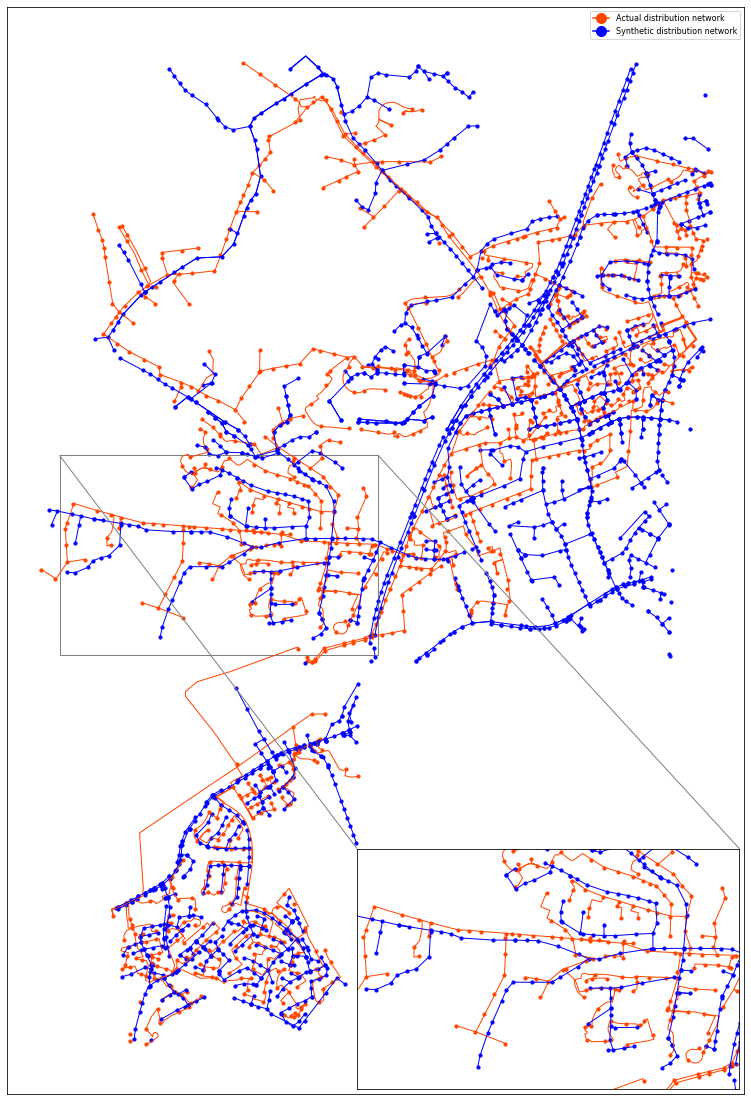

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

ymin_mega = 37.22809232474784
ymin_mega = 37.20809232474784
ymax_mega = 37.26242988929772 
xmin_mega = -80.46328349584152 
xmax_mega = -80.41701348914795

ymin_mini = 37.23 
ymax_mini = 37.24 
xmin_mini = -80.46
xmax_mini = -80.44

fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111)
        
for area in V.area_data:
    V.compare_networks(ax,V.area_data[area]['df_lines'],
                        V.area_data[area]['df_buses'],
                        V.area_data[area]['synthetic'])
#nx.draw_networkx(roads.graph,pos=roads.cord,with_labels=False,ax=ax,node_size=1.0,node_color='black',edge_color='black',width=0.3,style='dashed')
ax.set_xlim(xmin_mega,xmax_mega)
ax.set_ylim(ymin_mega,ymax_mega)

axins = zoomed_inset_axes(ax, 1.2, loc=4)
axins.set_aspect(1.6)
for area in V.area_data:
    V.compare_networks(axins,V.area_data[area]['df_lines'],
                        V.area_data[area]['df_buses'],
                        V.area_data[area]['synthetic'],
                      legend=False)

axins.set_xlim(xmin_mini,xmax_mini)
axins.set_ylim(ymin_mini,ymax_mini)
axins.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")

fig.savefig("{}{}.png".format(figpath,'structure-comparison'),
            bbox_inches='tight')

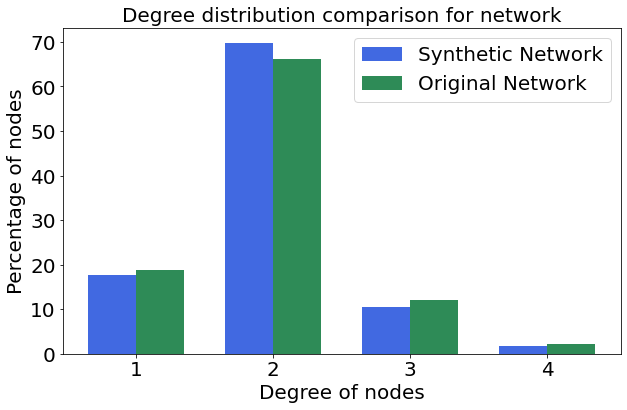

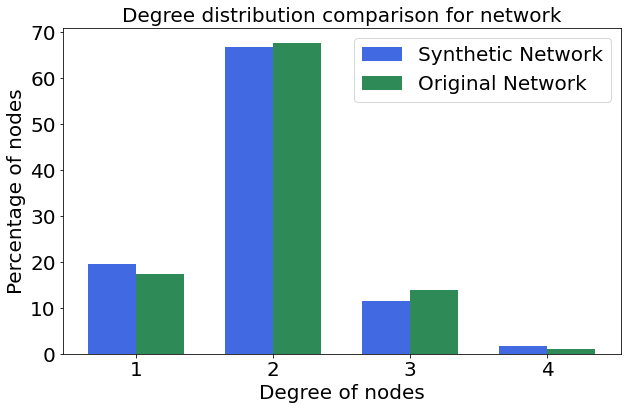

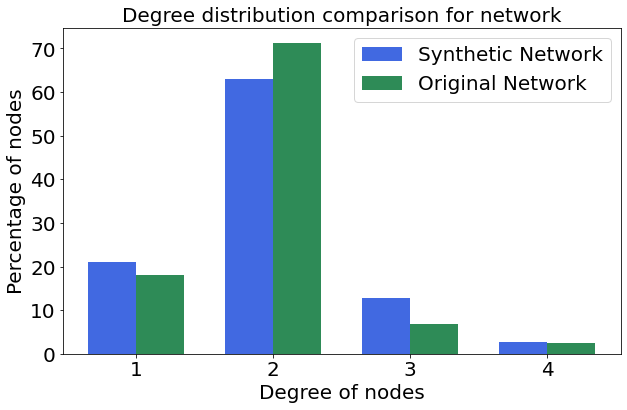

In [19]:
V.degree_dist(figpath)

In [8]:
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = "{0:.1f}".format(100*y)
    return s

def hop_dist(area_data,path):
    """
    Creates the hop distribution of the networks. The synthetic network is compared
    with a base network. The hop distribution of both the networks is plotted 
    together in a stacked plot/histogram.

    Inputs: path: path to save the plot
    """
    for area in area_data:
        sub = area_data[area]['root']
        synth = area_data[area]['synthetic']
        act = area_data[area]['actual']
        h1 = []
        for n in list(synth.nodes()):
            hops = [nx.shortest_path_length(synth_net,n,s) if nx.has_path(synth_net,n,s) \
                    else 1e9 for s in sublist]
            h1.append(min(hops))
        w1 = np.ones_like(h1)/float(len(h1))
        h2 = [nx.shortest_path_length(act,n,sub) for n in list(act.nodes())]
        w2 = np.ones_like(h2)/float(len(h2))

        # Plot the hop distribution
        hops = [h1,h2]
        w = [w1,w2]
        
        colors = ['blue','orangered']
        labels = ['synthetic network','actual network']
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)
        ax.hist(hops,weights=w,label=labels,color=colors)
        ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
        ax.set_ylabel("Percentage of nodes",fontsize=20)
        ax.set_xlabel("Hops from root node",fontsize=20)
        ax.legend(prop={'size': 20})
        ax.tick_params(axis='both', labelsize=20)

        # Save the figure
        filename = "hop-dist-"+str(sub)
        fig.savefig("{}{}.png".format(path,filename),bbox_inches='tight')
    return

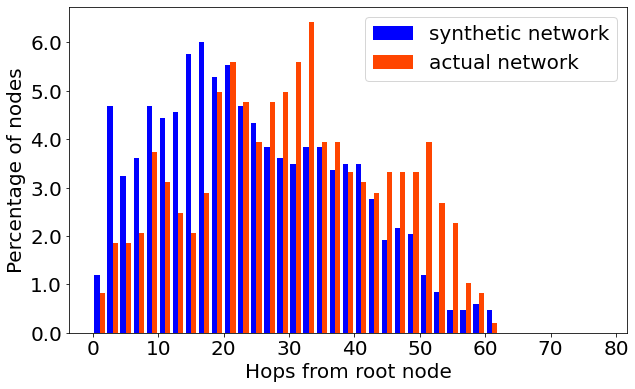

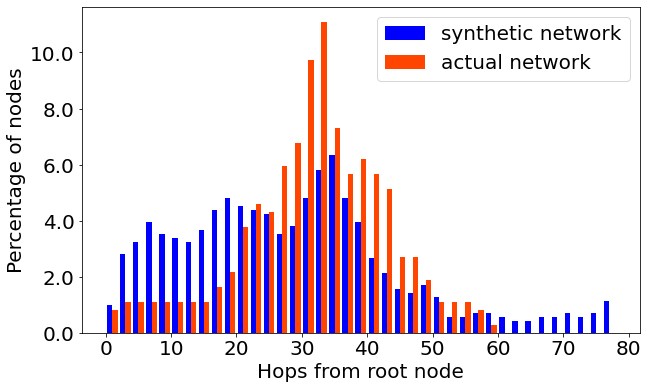

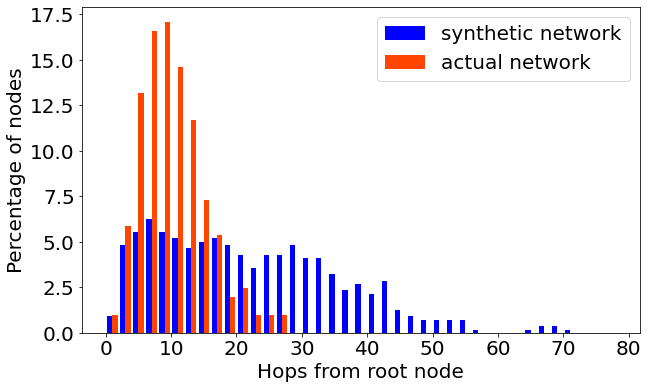

In [9]:
hop_dist(V.area_data,figpath)

In [27]:
def reach_dist(area_data,path):
    """
    Creates the hop distribution of the networks. The synthetic network is compared
    with a base network. The hop distribution of both the networks is plotted 
    together in a stacked plot/histogram.

    Inputs: path: path to save the plot
    """
    for area in area_data:
        sub = area_data[area]['root']
        synth = area_data[area]['synthetic']
        act = area_data[area]['actual']
        ageom = area_data[area]['line_geom']
        actgeom = {e:Link(ageom[e]) for e in ageom}
        geo_length = {e:actgeom[e].geod_length for e in ageom}
        nx.set_edge_attributes(act,geo_length,'geo_length')
        h1 = []
        for n in list(synth.nodes()):
            hops = [nx.shortest_path_length(synth_net,n,s,weight='geo_length') if nx.has_path(synth_net,n,s) \
                    else 1e12 for s in sublist]
            h1.append(min(hops))
        w1 = np.ones_like(h1)/float(len(h1))
        h2 = [nx.shortest_path_length(act,n,sub,weight='geo_length') for n in list(act.nodes())]
        w2 = np.ones_like(h2)/float(len(h2))

        # Plot the hop distribution
        hops = [h1,h2]
        w = [w1,w2]
        bins = range(0,40,2)
        colors = ['blue','orangered']
        labels = ['synthetic network','actual network']
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)
        ax.hist(hops,weights=w,label=labels,color=colors)
        ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
        ax.set_ylabel("Percentage of nodes",fontsize=20)
        ax.set_xlabel("Distance from root node",fontsize=20)
        ax.legend(prop={'size': 20})
        ax.tick_params(axis='both', labelsize=20)

        # Save the figure
        filename = "reach-dist-"+str(sub)
        fig.savefig("{}{}.png".format(path,filename),bbox_inches='tight')
    return

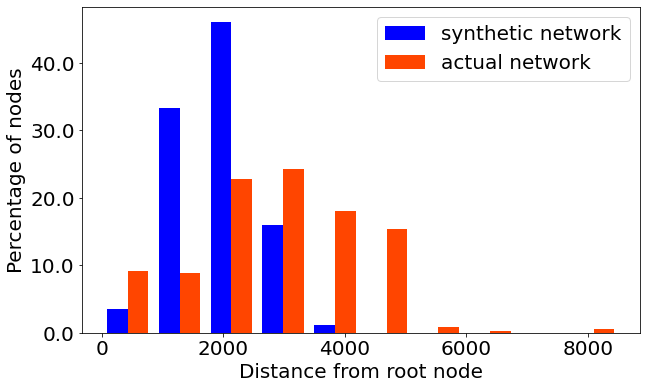

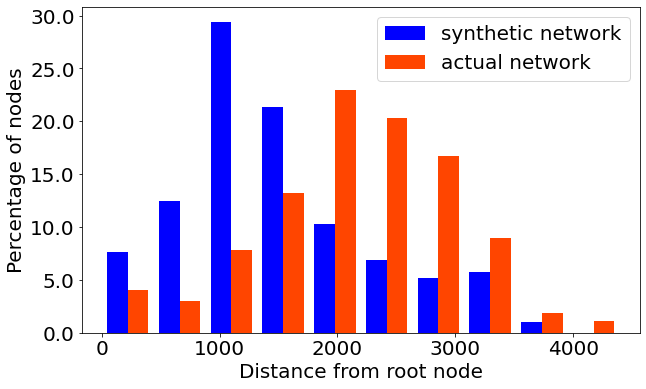

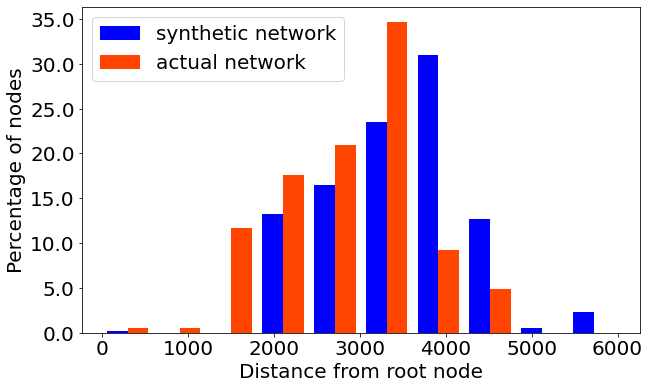

In [28]:
reach_dist(V.area_data,figpath)